# Reconocimiento Facial Basico (Regresion Logística)

Ejemplo de como se puede aplicar Regresión logística para clasificar expresiones faciales.

Para este caso, solo vamos a utilizar 2 clases para poder utilizar una clasificación binaria con una sigmoide.

En otros notebooks se implementará softmax para el caso *multiclase*.

In [18]:
from __future__ import print_function, division
from builtins import range

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [19]:
# Solo vamos a leer 2 clases - sino usariamos getData( ).
# Los datos estan en un fichero csv con la siguiente estructura:
# - emotion - numero de 0 a 6 (0-Angry, 1-Disgust, 2-Fear, 3-Happy, 4-Sad, 5-Surprise, 6-Neutral)
# - pixels - imagen de 48 x 48 pixels (no tiene color, solo 255 tonos de grises)
# - Usage - training o test

# Devuelve un array X( ) de todos los pixels de cada imagen 
# y un vector Y( ) con las etiquetas

def getBinaryData():
    Y = []
    X = []
    first = True # para saltarnos la primera linea
    for line in open('/home/jorge/data/facial_expressions/fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')   # separamos los datos usando la ","
            y = int(row[0])         # guardo el tipo de expresion en el target

            if y == 0 or y == 1:    # solo nos quedamos con estos tipos de expresion
                Y.append(y)
                X.append([int(p) for p in row[1].split()])
                
    return np.array(X) / 255.0, np.array(Y)        # Aqui normalizamos los datos X dividiendo por 255
                                                   # entonces nos quedan entre 0 y 1

In [20]:
def sigmoid(A):
    return 1 / (1 + np.exp(-A))

In [21]:
# Usamos cross-entropy como funcion de coste
def sigmoid_cost(T, Y):
    return -(T*np.log(Y) + (1-T)*np.log(1-Y)).sum()

In [22]:
# La tasa de error será la media de la diferencia entre targets y predicciones
def error_rate(targets, predictions):
    return np.mean(targets != predictions)          # nos quedamos con la media de los que son diferentes

In [23]:
class LogisticModel(object):
    def __init__(self):            # en este caso el constructor no tiene accion
        pass

    def fit(self, X, Y, learning_rate=10e-7, reg=0*10e-22, epochs=120000, show_fig=False):
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        N, D = X.shape
        self.W = np.random.randn(D) / np.sqrt(D)
        self.b = 0

        costs = []
        best_validation_error = 1
        for i in range(epochs):
                # forward propagation and cost calculation
                pY = self.forward(X)

                # Calculamos el descenso de gradiente para los pesos y el bias 
                self.W -= learning_rate*(X.T.dot(pY - Y) + reg*self.W)
                self.b -= learning_rate*((pY - Y).sum() + reg*self.b)

                # cada 12.000 epochs vemos la funcion de coste y el error
                if i % 12000 == 0:
                    pYvalid = self.forward(Xvalid)
                    c = sigmoid_cost(Yvalid, pYvalid)
                    costs.append(c)
                    e = error_rate(Yvalid, np.round(pYvalid))
                    print("i:", i, "cost:", c, "error:", e)
                    if e < best_validation_error:
                        best_validation_error = e
        print("Mejor Error de validacion:", best_validation_error)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def JEC_fit(self, X, Y, learning_rate=10e-7, reg=0*10e-22, epochs=120000):
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        N, D = X.shape
        self.W = np.random.randn(D) / np.sqrt(D)
        self.b = 0

        costs = []
        best_validation_error = 1
        for i in range(epochs):
                # forward propagation and cost calculation
                pY = self.forward(X)

                # Calculamos el descenso de gradiente para los pesos y el bias 
                self.W -= learning_rate*(X.T.dot(pY - Y) + reg*self.W)
                self.b -= learning_rate*((pY - Y).sum() + reg*self.b)

                # cada 10000 epochs vemos la funcion de coste y el error
                if i % 1000 == 0:
                    pYvalid = self.forward(Xvalid)
                    c = sigmoid_cost(Yvalid, pYvalid)
                    costs.append(c)
                    e = error_rate(Yvalid, np.round(pYvalid))
                    print("i:", i, "cost:", c, "error:", e)
                    if e < best_validation_error:
                        best_validation_error = e
        print("Mejor Error de validacion:", best_validation_error)
        return costs

    def forward(self, X):
        return sigmoid(X.dot(self.W) + self.b)

    def predict(self, X):
        pY = self.forward(X)
        return np.round(pY)


    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)


In [24]:
# Solo nos quedamos con 2 clases del dataset de 'Expresiones Faciales', la 0 y la 1 ((0-Angry, 1-Disgust)
X, Y = getBinaryData()

# Separamos los 2 grupos
X0 = X[Y==0, :]
X1 = X[Y==1, :]


In [25]:
# y vemos las cantidades de cada uno
print(X0.shape)
print(X1.shape)

(4953, 2304)
(547, 2304)


Vemos que hay un desbalance de clases. Una forma de solucionarlo, y para no quedarnos con menos datos, es repitiendo la clase con menos muestras.

In [26]:
X1 = np.repeat(X1, 9, axis=0)
X = np.vstack([X0, X1])
Y = np.array([0]*len(X0) + [1]*len(X1))

# N, D = X.shape
# print "N:", N
# print "p(Y=0):", np.sum(Y == 0) / float(N), "p(Y=1):", np.sum(Y == 1) / float(N)
    
print(X0.shape)
print(X1.shape)
print(X.shape)

(4953, 2304)
(4923, 2304)
(9876, 2304)


In [27]:
# Entrenamos

model = LogisticModel() # instancio un objeto de la clase LogisticModel

# hice una pequeña modificacion en el codigo de la clase para que al hacer model.fit() 
# devuelva los costes segun se ha ido entrenando. 
lista_costs=model.JEC_fit(X, Y, epochs=120000)

i: 0 cost: 704.68936799 error: 0.501
i: 1000 cost: 589.549539395 error: 0.31
i: 2000 cost: 565.002873786 error: 0.298
i: 3000 cost: 548.528871368 error: 0.28
i: 4000 cost: 536.140846348 error: 0.272
i: 5000 cost: 526.307084588 error: 0.256
i: 6000 cost: 518.223504619 error: 0.247
i: 7000 cost: 511.40636945 error: 0.243
i: 8000 cost: 505.541423921 error: 0.239
i: 9000 cost: 500.413726964 error: 0.233
i: 10000 cost: 495.87047278 error: 0.228
i: 11000 cost: 491.799630404 error: 0.227
i: 12000 cost: 488.116955477 error: 0.222
i: 13000 cost: 484.757738243 error: 0.222
i: 14000 cost: 481.671367823 error: 0.219
i: 15000 cost: 478.817640046 error: 0.217
i: 16000 cost: 476.16418227 error: 0.22
i: 17000 cost: 473.684615388 error: 0.218
i: 18000 cost: 471.357215242 error: 0.213
i: 19000 cost: 469.163920301 error: 0.211
i: 20000 cost: 467.089584398 error: 0.211
i: 21000 cost: 465.121406132 error: 0.211
i: 22000 cost: 463.248487703 error: 0.21
i: 23000 cost: 461.46148999 error: 0.208
i: 24000 cost:

In [28]:
model.score(X, Y)
# scores = cross_val_score(model, X, Y, cv=5)
# print "score mean:", np.mean(scores), "stdev:", np.std(scores)

0.87363304981774004

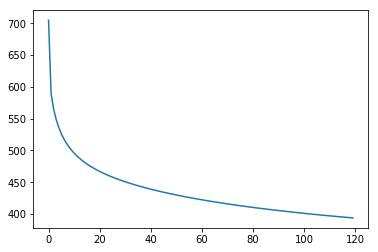

In [29]:
plt.plot(lista_costs)
plt.show()